In [1]:
# Convergence criteria
# IRL Papers: Evaluation
# Initialization of weights
# Gridworld environment

In [2]:
import json
import sys
sys.path.append('../simulated_fqi/')
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import torch
import random
import shap
import configargparse
import torch
import torch.optim as optim

from environments import CartPoleRegulatorEnv
from environments import CartEnv
from environments import AcrobotEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
from train import fqi
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [3]:
def runFQI(
verbose=True, 
is_contrastive=False, 
epoch=1000, 
init_experience=200, 
evaluations=5, 
force_left=5, 
random_seed=None, 
reward_weights_shared=np.asarray([0.1] * 5),
reward_weights_fg = np.asarray([0.1] * 5),
use_weights=True
):
    # Setup environment
    bg_cart_mass = 1.0
    fg_cart_mass = 1.0
    train_env_bg = CartPoleRegulatorEnv(
        group=0,
        masscart=bg_cart_mass,
        mode="train",
        force_left=force_left,
        is_contrastive=is_contrastive,
    )
    train_env_fg = CartPoleRegulatorEnv(
        group=1,
        masscart=fg_cart_mass,
        mode="train",
        force_left=force_left,
        is_contrastive=is_contrastive,
    )
    eval_env_bg = CartPoleRegulatorEnv(
        group=0,
        masscart=bg_cart_mass,
        mode="eval",
        force_left=force_left,
        is_contrastive=is_contrastive,
    )
    eval_env_fg = CartPoleRegulatorEnv(
        group=1,
        masscart=fg_cart_mass,
        mode="eval",
        force_left=force_left,
        is_contrastive=is_contrastive,
    )

    # Log to File, Console, TensorBoard, W&B
    logger = get_logger()
    
    # NFQ Main loop
    bg_rollouts = []
    fg_rollouts = []
    total_cost = 0
    if init_experience > 0:
        for _ in range(init_experience):
            rollout_bg, episode_cost = train_env_bg.generate_rollout(
                None, render=False, group=0
            )
            rollout_fg, episode_cost = train_env_fg.generate_rollout(
                None, render=False, group=1
            )
            bg_rollouts.extend(rollout_bg)
            fg_rollouts.extend(rollout_fg)
            total_cost += episode_cost
    bg_rollouts.extend(fg_rollouts)
    all_rollouts = bg_rollouts.copy()

    bg_rollouts_test = []
    fg_rollouts_test = []
    if init_experience > 0:
        for _ in range(init_experience):
            rollout_bg, episode_cost = eval_env_bg.generate_rollout(
                None, render=False, group=0
            )
            rollout_fg, episode_cost = eval_env_fg.generate_rollout(
                None, render=False, group=1
            )
            bg_rollouts_test.extend(rollout_bg)
            fg_rollouts_test.extend(rollout_fg)
    bg_rollouts_test.extend(fg_rollouts)
    all_rollouts_test = bg_rollouts_test.copy()
    # Setup agent
    nfq_net = ContrastiveNFQNetwork(
        state_dim=train_env_bg.state_dim, is_contrastive=is_contrastive
    )

    if is_contrastive:
        optimizer = optim.Adam(
            itertools.chain(
                nfq_net.layers_shared.parameters(),
                nfq_net.layers_last_shared.parameters(),
            ),
            lr=1e-1,
        )
    else:
            optimizer = optim.Adam(nfq_net.parameters(), lr=1e-1)
    nfq_agent = NFQAgent(nfq_net, optimizer)

    bg_success_queue = [0] * 3
    fg_success_queue = [0] * 3
    epochs_fg = 0
    eval_fg = 0
    for k, epoch in enumerate(tqdm.tqdm(range(epoch + 1))):

        state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(
            all_rollouts, reward_weights_shared=reward_weights_shared, reward_weights_fg=reward_weights_fg, use_weights=use_weights
        )
        X = state_action_b
        train_groups = groups

        if not nfq_net.freeze_shared:
            loss = nfq_agent.train((state_action_b, target_q_values, groups))

        eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = 0, 0, 0
        if nfq_net.freeze_shared:
            eval_fg += 1

            if eval_fg > 50:
                loss = nfq_agent.train((state_action_b, target_q_values, groups))
        (
            eval_episode_length_bg,
            eval_success_bg,
            eval_episode_cost_bg,
        ) = nfq_agent.evaluate(eval_env_bg, render=False)
        (
            eval_episode_length_fg,
            eval_success_fg,
            eval_episode_cost_fg,
        ) = nfq_agent.evaluate(eval_env_fg, render=False)

        bg_success_queue = bg_success_queue[1:]
        bg_success_queue.append(1 if eval_success_bg else 0)

        fg_success_queue = fg_success_queue[1:]
        fg_success_queue.append(1 if eval_success_fg else 0)

        printed_bg = False
        printed_fg = False

        if sum(bg_success_queue) == 3 and not nfq_net.freeze_shared == True:
            if epochs_fg == 0:
                epochs_fg = epoch
            printed_bg = True
            nfq_net.freeze_shared = True
            if verbose:
                print("FREEZING SHARED")
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = False

            optimizer = optim.Adam(
                itertools.chain(
                    nfq_net.layers_fg.parameters(),
                    nfq_net.layers_last_fg.parameters(),
                ),
                lr=1e-1,
            )
            nfq_agent._optimizer = optimizer

        # Print current status
#         if verbose:
#             logger.info(
#                 "Epoch {:4d} | Eval BG {:4d} / {:4f} | Eval FG {:4d} / {:4f} | Train Loss {:.4f}".format(
#                     epoch,
#                     eval_episode_length_bg,
#                     eval_episode_cost_bg,
#                     eval_episode_length_fg,
#                     eval_episode_cost_fg,
#                     loss,
#                 )
#             )
        if sum(fg_success_queue) == 3:
            printed_fg = True
            break

    eval_env_bg.step_number = 0
    eval_env_fg.step_number = 0

    eval_env_bg.max_steps = 1000
    eval_env_fg.max_steps = 1000

    performance_fg = []
    performance_bg = []
    num_steps_bg = []
    num_steps_fg = []
    total = 0
    for it in range(evaluations):
        (
            eval_episode_length_bg,
            eval_success_bg,
            eval_episode_cost_bg,
        ) = nfq_agent.evaluate(eval_env_bg, False)
        if verbose:
            print(eval_episode_length_bg, eval_success_bg)
        num_steps_bg.append(eval_episode_length_bg)
        performance_bg.append(eval_episode_length_bg)
        total += 1
        train_env_bg.close()
        eval_env_bg.close()

        (
            eval_episode_length_fg,
            eval_success_fg,
            eval_episode_cost_fg,
        ) = nfq_agent.evaluate(eval_env_fg, False)
        if verbose:
            print(eval_episode_length_fg, eval_success_fg)
        num_steps_fg.append(eval_episode_length_fg)
        performance_fg.append(eval_episode_length_fg)
        total += 1
        train_env_fg.close()
        eval_env_fg.close()
    print("Fg trained after " + str(epochs_fg) + " epochs")
    print("BG stayed up for steps: ", num_steps_bg)
    print("FG stayed up for steps: ", num_steps_fg)
    
    bg_rollouts = []
    fg_rollouts = []
    total_cost = 0
    if init_experience > 0:
        for _ in range(init_experience):
            rollout_bg, episode_cost = train_env_bg.generate_rollout(
                nfq_agent, render=False, group=0
            )
            rollout_fg, episode_cost = train_env_fg.generate_rollout(
                nfq_agent, render=False, group=1
            )
            bg_rollouts.extend(rollout_bg)
            fg_rollouts.extend(rollout_fg)
            total_cost += episode_cost
    bg_rollouts.extend(fg_rollouts)
    policy_rollouts = bg_rollouts.copy()
    
    # Do a rollout of the policy 
    return policy_rollouts, nfq_agent

In [4]:
def find_feature_expectations(dataset, shared=True):
    if shared:
        features_obs = []
        actions = []
        for sample in dataset:
            obs = sample[0]
            action = sample[1]
            actions.append(action)
            features_obs.append(obs)
        features_obs = np.asarray(features_obs)
        avg_action = sum(actions)/len(actions)
        feature_expecs = np.average(features_obs, axis=0)
        feature_expecs = np.append(feature_expecs, [avg_action])
    else:
        # Only perform for foreground samples
        features_obs = []
        actions = []
        for sample in dataset:
            group = sample[-1]
            if group == 1:
                obs = sample[0]
                action = sample[1]
                actions.append(action)
                features_obs.append(obs)
        features_obs = np.asarray(features_obs)
        avg_action = sum(actions)/len(actions)
        feature_expecs = np.average(features_obs, axis=0)
        feature_expecs = np.append(feature_expecs, [avg_action])
    
    return feature_expecs
def norm(vec):
    return vec/np.sum(np.abs(vec))            

Generating behavior


WARN: Box bound precision lowered by casting to float32
  8%|▊         | 76/1001 [00:20<17:02,  1.11s/it]

FREEZING SHARED


  8%|▊         | 80/1001 [00:35<06:49,  2.25it/s]


522 False
1000 True
1000 True
1000 True
1000 True
1000 True
1000 True
1000 True
1000 True
395 False
Fg trained after 75 epochs
BG stayed up for steps:  [522, 1000, 1000, 1000, 1000]
FG stayed up for steps:  [1000, 1000, 1000, 1000, 395]
Epoch 0 - Train pi with current w_shared=[10, 10, 10, 10, 10] w_fg= [10, 10, 10, 10, 10]


100%|██████████| 1001/1001 [01:33<00:00, 10.69it/s]


22 False
22 False
21 False
17 False
25 False
17 False
21 False
17 False
21 False
19 False
Fg trained after 0 epochs
BG stayed up for steps:  [22, 21, 25, 21, 21]
FG stayed up for steps:  [22, 17, 17, 17, 19]
Evaluate feature expectations for pi
Initialize behaviour mu_shared:
Initialize behaviour mu_fg:
Gradient update for new w
Epoch 1 - Train pi with current w_shared=[0.19968892 0.20041502 0.19967371 0.19871479 0.20150755] w_fg= [0.19971117 0.20061232 0.1996455  0.19866595 0.20136507]


WARN: Box bound precision lowered by casting to float32
 10%|▉         | 97/1001 [00:30<31:17,  2.08s/it]

FREEZING SHARED


 12%|█▏        | 118/1001 [01:29<11:10,  1.32it/s]


1000 True
1000 True
1000 True
1000 True
95 False
135 False
1000 True
69 False
1000 True
93 False
Fg trained after 96 epochs
BG stayed up for steps:  [1000, 1000, 95, 1000, 1000]
FG stayed up for steps:  [1000, 1000, 135, 69, 93]
Evaluate feature expectations for pi
Gradient update for new w
Converged


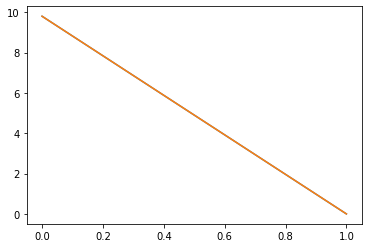

In [5]:
epochs=15; learning_rate=0.1; init_w_shared = [10]*5; init_w_fg = [10]*5
w_shared = init_w_shared
w_fg = init_w_fg

muB_shared = None
muB_fg = None

diff_shared = []
diff_fg = []

delta = 1e-2

print("Generating behavior")
behavior_rollout, opt_agent = runFQI(is_contrastive=True, use_weights=False)

# Abs value of elt 2 and 0
# We know reward function is block --> transform to step (better approximated w/ linear fn)
# How do we update policy
for i in range(epochs):
    print('Epoch', i, '- Train pi with current w_shared='+str(w_shared) + " w_fg=", w_fg )
#     try:
    policy_rollout, agent_pi = runFQI(reward_weights_shared=w_shared, reward_weights_fg=w_fg)

    print('Evaluate feature expectations for pi')
    # Generate rollout with this policy, then do feature expectations
    mu_shared = find_feature_expectations(policy_rollout, shared=True)
    mu_fg = find_feature_expectations(policy_rollout, shared=False)

    if muB_shared is None:
        print('Initialize behaviour mu_shared:')
        muB_shared = find_feature_expectations(behavior_rollout, shared=True)
    if muB_fg is None:
        print('Initialize behaviour mu_fg:')
        muB_fg = find_feature_expectations(behavior_rollout, shared=False)

    print('Gradient update for new w')
    grad_shared = norm(muB_shared) - norm(mu_shared)
    grad_fg = norm(muB_fg) - norm(mu_fg)
    
    w_shared_old = w_shared
    w_shared += learning_rate*(0.95**i) * grad_shared
    w_shared = w_shared/np.sum(np.abs(w_shared))
    
    w_fg_old = w_fg
    w_fg += learning_rate*(0.95**i) * grad_fg
    w_fg = w_fg/np.sum(np.abs(w_fg))
    
    diff_shared.append(mean_absolute_error(w_shared_old, w_shared))
    diff_fg.append(mean_absolute_error(w_fg_old, w_fg))
    
    if abs(diff_shared[-1]) < delta and abs(diff_fg[-1]) < delta:
        print("Converged")
        break

plt.plot(diff_shared)
plt.plot(diff_fg)

In [6]:
w_fg

array([0.18387565, 0.21841495, 0.19053697, 0.16585704, 0.2413154 ])

In [7]:
w_shared

array([0.17655206, 0.20522903, 0.19676828, 0.1810286 , 0.24042204])

# Evaluation

In [8]:
policy_rollout, nfq_agent = runFQI(reward_weights_shared=w_shared, reward_weights_fg=w_fg)

WARN: Box bound precision lowered by casting to float32
 10%|█         | 102/1001 [00:58<37:14,  2.49s/it]

FREEZING SHARED


 15%|█▍        | 146/1001 [02:57<17:16,  1.21s/it]


66 False
34 False
27 False
66 False
1000 True
42 False
42 False
1000 True
67 False
1000 True
Fg trained after 101 epochs
BG stayed up for steps:  [66, 27, 1000, 42, 67]
FG stayed up for steps:  [34, 66, 42, 1000, 1000]


In [9]:
unique_actions = np.array([0, 1])
correct = 0
total = 0
for i, tup in enumerate(tqdm.tqdm(behavior_rollout)):
    obs = tup[0]
    action_b = tup[1]
    group_b = tup[-1]
    action_opt = opt_agent.get_best_action(obs, unique_actions, group_b)
    action_pi = nfq_agent.get_best_action(obs, unique_actions, group_b)
    if action_pi == action_opt:
        correct += 1
    total += 1
print("Correct: " + str(correct/total) + "%")

100%|██████████| 36966/36966 [00:45<00:00, 813.41it/s]

Correct: 0.5970892171184331%


## Recover the reward function?
* Can evaluate this by densely sampling the state space

In [10]:
def plot_reward(agent, title='Recovered Reward'):
    positions = [i/10 for i in range(-48, 48)]
    thetas = [i for i in range(-24, 24)]
    x_success_range = 2.4
    theta_success_range = 12 * 2 * math.pi / 360
    reward_matrix = np.zeros((len(thetas), len(positions)))
    # For both actions
    for i, pos in enumerate(positions):
        for j, theta in enumerate(thetas):
            s = [pos, 0, theta, 0]
            a = agent.get_best_action(s, unique_actions, 1)
            s = torch.Tensor(s)
            a = torch.Tensor([a])        
            s_a = torch.cat([s, a], 0)
            reward = agent._nfq_net(s_a).cpu().detach().tolist()[0]

            reward_matrix[j,i] = reward
    plt.figure(figsize=(14, 5))
    sns.heatmap(reward_matrix, xticklabels=positions, yticklabels=thetas)
    plt.xlabel("Cart Position")
    plt.ylabel("Pole Angle")
    plt.title(title)
    

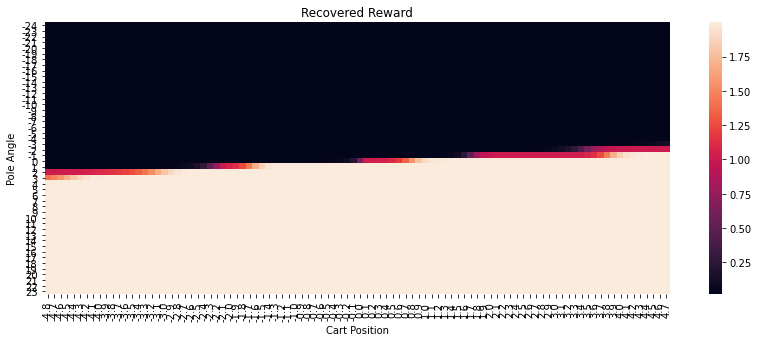

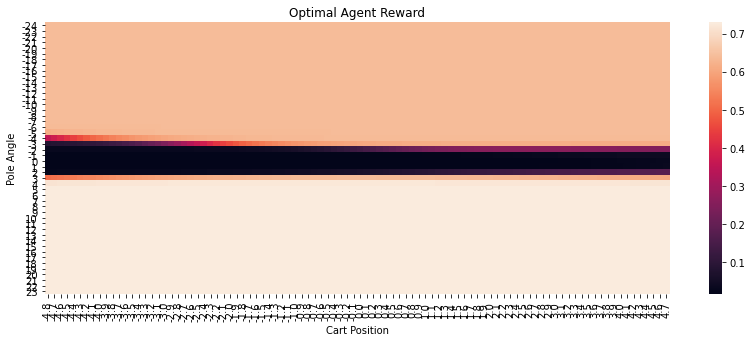

In [11]:
plot_reward(nfq_agent)
plot_reward(opt_agent, "Optimal Agent Reward")

Text(0.5, 1.0, 'Actual Reward')

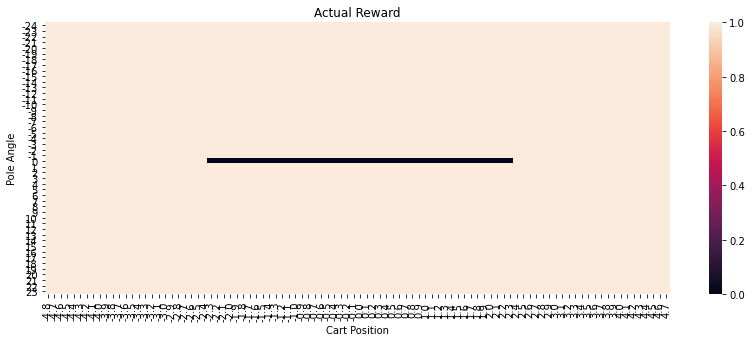

In [12]:
positions = [i/10 for i in range(-48, 48)]
thetas = [i for i in range(-24, 24)]
x_success_range = 2.4
theta_success_range = 12 * 2 * math.pi / 360
reward_matrix = np.zeros((len(thetas), len(positions)))
# For both actions
for i, pos in enumerate(positions):
    for j, theta in enumerate(thetas):
        if -x_success_range < pos < x_success_range and -theta_success_range < theta < theta_success_range:
                reward = 0
        else:
            reward = 1

        reward_matrix[j,i] = reward
plt.figure(figsize=(14, 5))
sns.heatmap(reward_matrix, xticklabels=positions, yticklabels=thetas)
plt.xlabel("Cart Position")
plt.ylabel("Pole Angle")
plt.title("Actual Reward")